In [ ]:
%%time
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data

--2021-10-28 20:52:30--  https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18461 (18K) [application/x-httpd-php]
Saving to: ‘processed.cleveland.data’

processed.cleveland 100%[===================>]  18.03K  --.-KB/s    in 0.06s   

2021-10-28 20:52:30 (285 KB/s) - ‘processed.cleveland.data’ saved [18461/18461]

CPU times: user 16.4 ms, sys: 5.66 ms, total: 22.1 ms
Wall time: 440 ms


**According to WARING FILE:**


```
The file cleveland.data has been unfortunately messed up when we lost
node cip2 and loaded the file on node ics.  The file processed.cleveland.data
seems to be in good shape and is useable (for the 14 attributes situation).
I'll clean up cleveland.data as soon as possible.

Bad news: my original copy of the database appears to be corrupted.
I'll have to go back to the donor to get a new copy.

David Aha

```

We need to use processed.cleveland.data (cleveland.data is still damaged).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from sklearn.model_selection import KFold

In [ ]:
df = pd.read_csv("processed.cleveland.data", header=None, na_values="?", names=["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"])
df.head()

age  sex   cp  trestbps   chol  fbs  ...  exang  oldpeak  slope   ca  thal  num
0  63.0  1.0  1.0     145.0  233.0  1.0  ...    0.0      2.3    3.0  0.0   6.0    0
1  67.0  1.0  4.0     160.0  286.0  0.0  ...    1.0      1.5    2.0  3.0   3.0    2
2  67.0  1.0  4.0     120.0  229.0  0.0  ...    1.0      2.6    2.0  2.0   7.0    1
3  37.0  1.0  3.0     130.0  250.0  0.0  ...    0.0      3.5    3.0  0.0   3.0    0
4  41.0  0.0  2.0     130.0  204.0  0.0  ...    0.0      1.4    1.0  0.0   3.0    0

[5 rows x 14 columns]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  num       303 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 33.3 KB


According to documentation columnt `num`:

```
-- 14. #58 (num)       (the predicted attribute)

  |
  |
  v

58 num: diagnosis of heart disease (angiographic disease status)
        -- Value 0: < 50% diameter narrowing
        -- Value 1: > 50% diameter narrowing

```

but:

In [ ]:
df["num"].value_counts()

0    164
1     55
2     36
3     35
4     13
Name: num, dtype: int64

So great work, nice docs, real Data Science here :)

[<img src="https://memegenerator.net/img/instances/50033360/welcome-to-reality.jpg">](https://www.youtube.com/watch?v=dQw4w9WgXcQ)


But we can create binnary clasifier so I am going to covert num>=1 to 1.


# NA VALUES

Data set contains NaN values. I did not replace them as for different classifiers we treat NaN differently (can be mean(), 0.0, max() or even excluded).



In [ ]:
def load_dataset(save=False):
  """
  This fuction is meant to be exported so this is why here download part repeats itself.
  """
  url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
  r = requests.get(url, allow_redirects=True)
  open('processed.cleveland.data', 'wb').write(r.content)

  df = pd.read_csv("processed.cleveland.data", header=None, na_values="?", names=["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"])
  df['num'].values[df['num'].values > 0] = 1
  df.dropna(inplace=True)
  if save:
    df.to_csv("cleveland.csv",index=False)

  return df


def cross_validation_data_set(df=load_dataset(), n_splits=10, n_repetitions=10):
  for i in range(n_repetitions):
    kf = KFold(n_splits = n_splits, shuffle = True)
    result = next(kf.split(df), None)

    train = df.iloc[result[0]]
    test =  df.iloc[result[1]]

    yield train, test

df = load_dataset(True)

In [ ]:
corr = df.corr(method='spearman')['num'].abs().sort_values()
corr

fbs         0.025264
chol        0.121122
trestbps    0.128166
restecg     0.169277
age         0.236674
sex         0.276816
slope       0.364425
oldpeak     0.413382
thalach     0.423467
exang       0.431894
cp          0.472006
ca          0.488602
thal        0.522202
num         1.000000
Name: num, dtype: float64

In [ ]:
# Helper function for plotting side by side by https://www.kaggle.com/heyrict/clinical-data-explanation-and-standard-eda-95
def sideplot(df, col, kind="bar", title=None):
    assert kind in ["bar", "hist"]
    fig = plt.figure(figsize=(10, 6))
    if kind == "bar":
        ax1 = plt.subplot(2, 2, 1)
        df[df.num == 1][['num', col]].groupby(col).count().plot(kind='bar', rot=0, legend=False, ax=ax1, color="red", title="with heart diseases")
        ax2 = plt.subplot(2, 2, 2)
        df[df.num == 0][['num', col]].groupby(col).count().plot(kind='bar', rot=0, legend=False, ax=ax2, color="blue", title="without heart diseases")

        for ax in [ax1, ax2]:
          for p in ax.patches:
            width = p.get_width()
            height = p.get_height()
            x, y = p.get_xy() 
            ax.annotate(f'{height}', (x + width/2, y + height*1.02), ha='center')

    else:
        ax1 = plt.subplot(2, 2, 1)
        plt.hist(df[df.num == 1][col], color="red")
        plt.xlabel(col)
        plt.title("with heart diseases")
        ax2 = plt.subplot(2, 2, 2)
        plt.hist(df[df.num == 0][col], color="blue")
        plt.xlabel(col)
        plt.title("without heart diseases")
    # Re-adjusting
    ylim = (0, max(ax1.get_ylim()[1], ax2.get_ylim()[1]))
    ax1.set_ylim(ylim)
    ax2.set_ylim(ylim)
    xlim = (min(ax1.get_xlim()[0], ax2.get_xlim()[0]), max(ax1.get_xlim()[1], ax2.get_xlim()[1]))
    ax1.set_xlim(xlim)
    ax2.set_xlim(xlim)
    if title is not None:
        fig.suptitle(title)
        fig.suptitle(title)
    #plt.subplots_adjust(top=0.99)



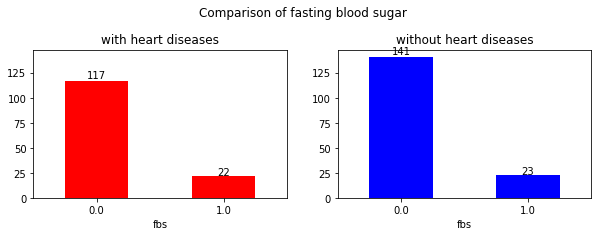

In [ ]:
sideplot(df, "fbs", kind="bar", title="Comparison of fasting blood sugar")

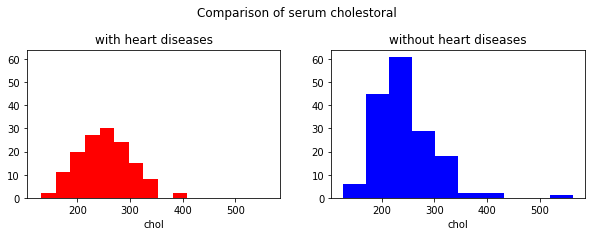

In [ ]:
sideplot(df, "chol", kind="hist", title="Comparison of serum cholestoral")

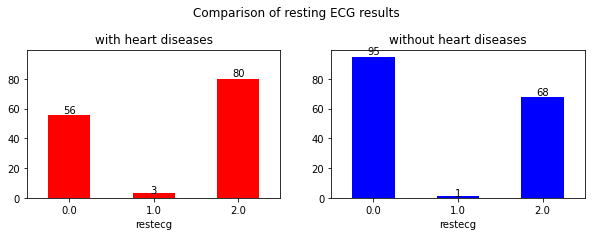

In [ ]:
sideplot(df, "restecg", kind="bar", title="Comparison of resting ECG results")

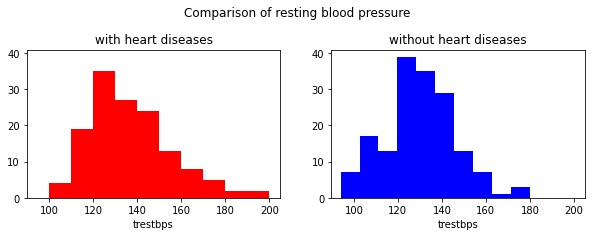

In [ ]:
sideplot(df, "trestbps", kind="hist", title="Comparison of resting blood pressure")

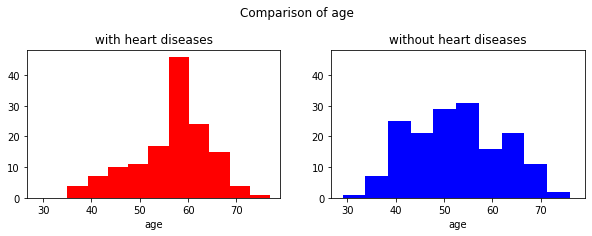

In [ ]:
sideplot(df, "age", kind="hist", title="Comparison of age")

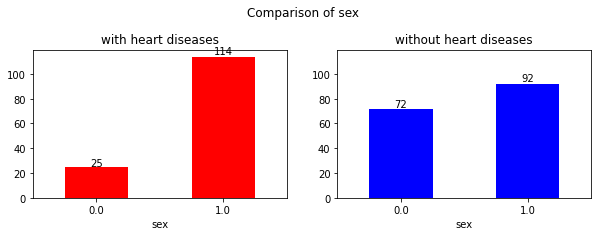

In [ ]:
sideplot(df, "sex", kind="bar", title="Comparison of sex")

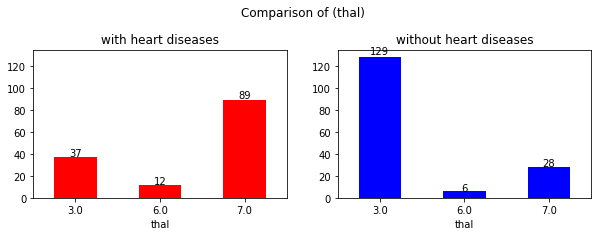

In [ ]:
sideplot(df, "thal", kind="bar", title="Comparison of results of thallium stress test)")

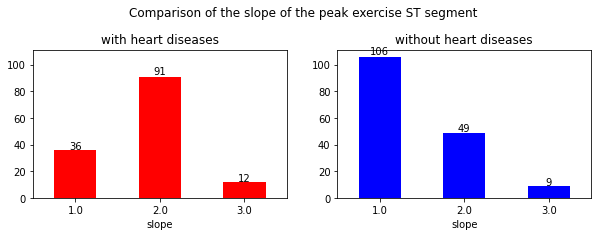

In [ ]:
sideplot(df, "slope", kind="bar", title="Comparison of the slope of the peak exercise ST segment")

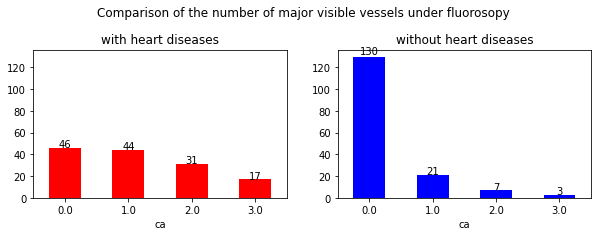

In [ ]:
sideplot(df, "ca", kind="bar", title="Comparison of the number of major visible vessels under fluorosopy")

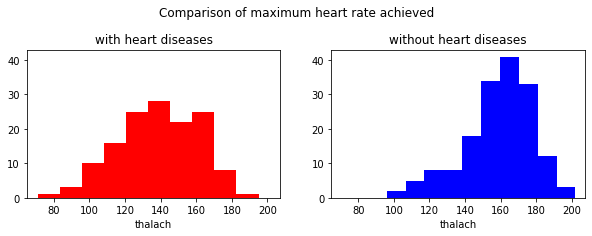

In [ ]:
sideplot(df, "thalach", kind="hist", title="Comparison of maximum heart rate achieved")

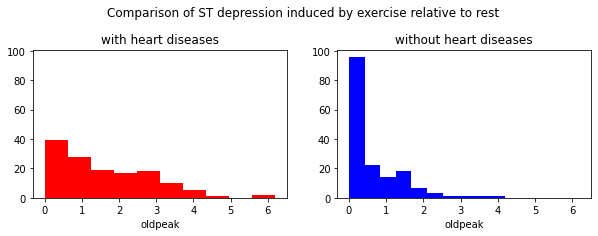

In [ ]:
sideplot(df, "oldpeak", kind="hist", title="Comparison of ST depression induced by exercise relative to rest")

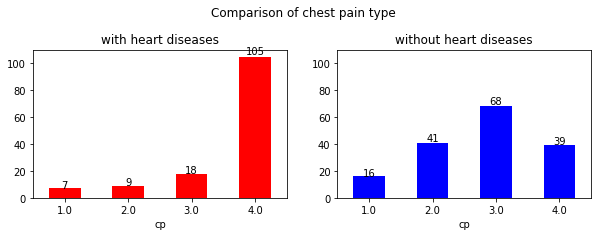

In [ ]:
sideplot(df, "cp", kind="bar", title="Comparison of chest pain type")

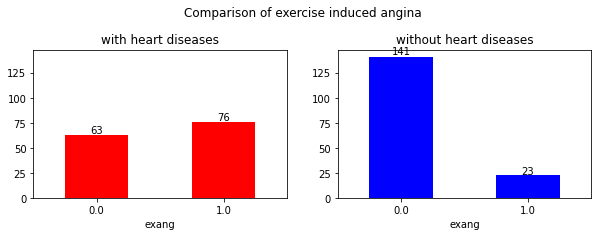

In [ ]:
sideplot(df, "exang", kind="bar", title="Comparison of exercise induced angina")